In [1]:
import numpy as np
from src.lattice import Lattice2D, BrickwallLatticeGeometry, RectangularLatticeGeometry, SimulationParameters
import matplotlib.pyplot as plt

In [5]:
omega = 2 * np.pi / 4

geometry = BrickwallLatticeGeometry((9, 20))
params = SimulationParameters(
    t_hop=1.0,
    E_amplitude=lambda t: np.sin(omega * t),
    E_direction=np.array([0, -1]),
    h=1e-3,
    T=10,
    charge=1,
    initial_occupation=0.5,
)

lattice = Lattice2D(geometry, params)
lattice.evolve(solver="rk4", use_sparse=True, sample_every=53)
lattice.save_current_density_animation("current_density_rk4_sparse.mp4", fps=8, sample_every=1)

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


 74%|███████▍  | 7388/10000 [00:28<00:10, 259.60it/s]


KeyboardInterrupt: 

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


  0%|          | 0/20000 [00:00<?, ?it/s]

Generating animation: 100%|██████████| 100/100 [00:37<00:00,  2.70frame/s]


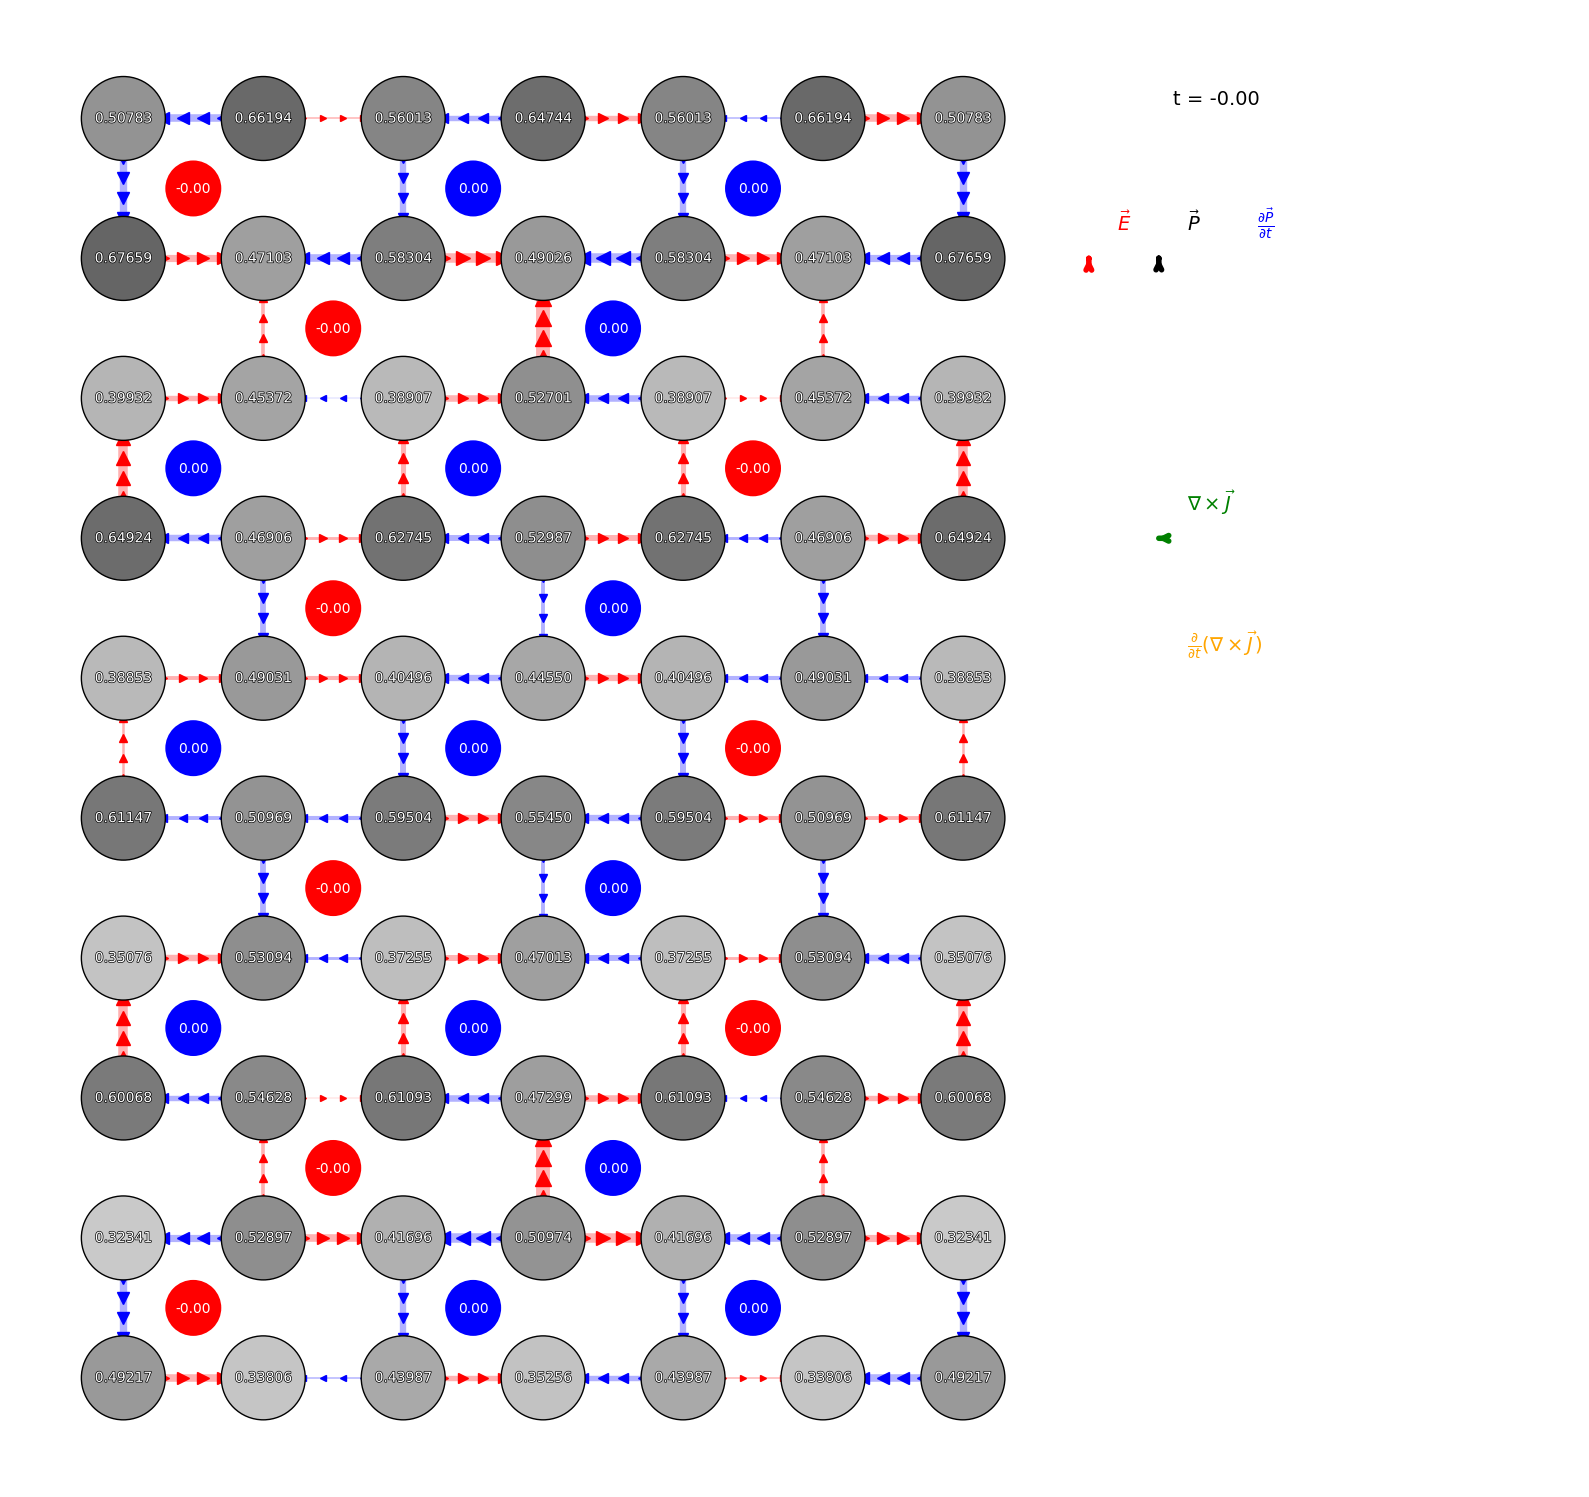

Generating animation: 100%|██████████| 100/100 [00:37<00:00,  2.65frame/s]


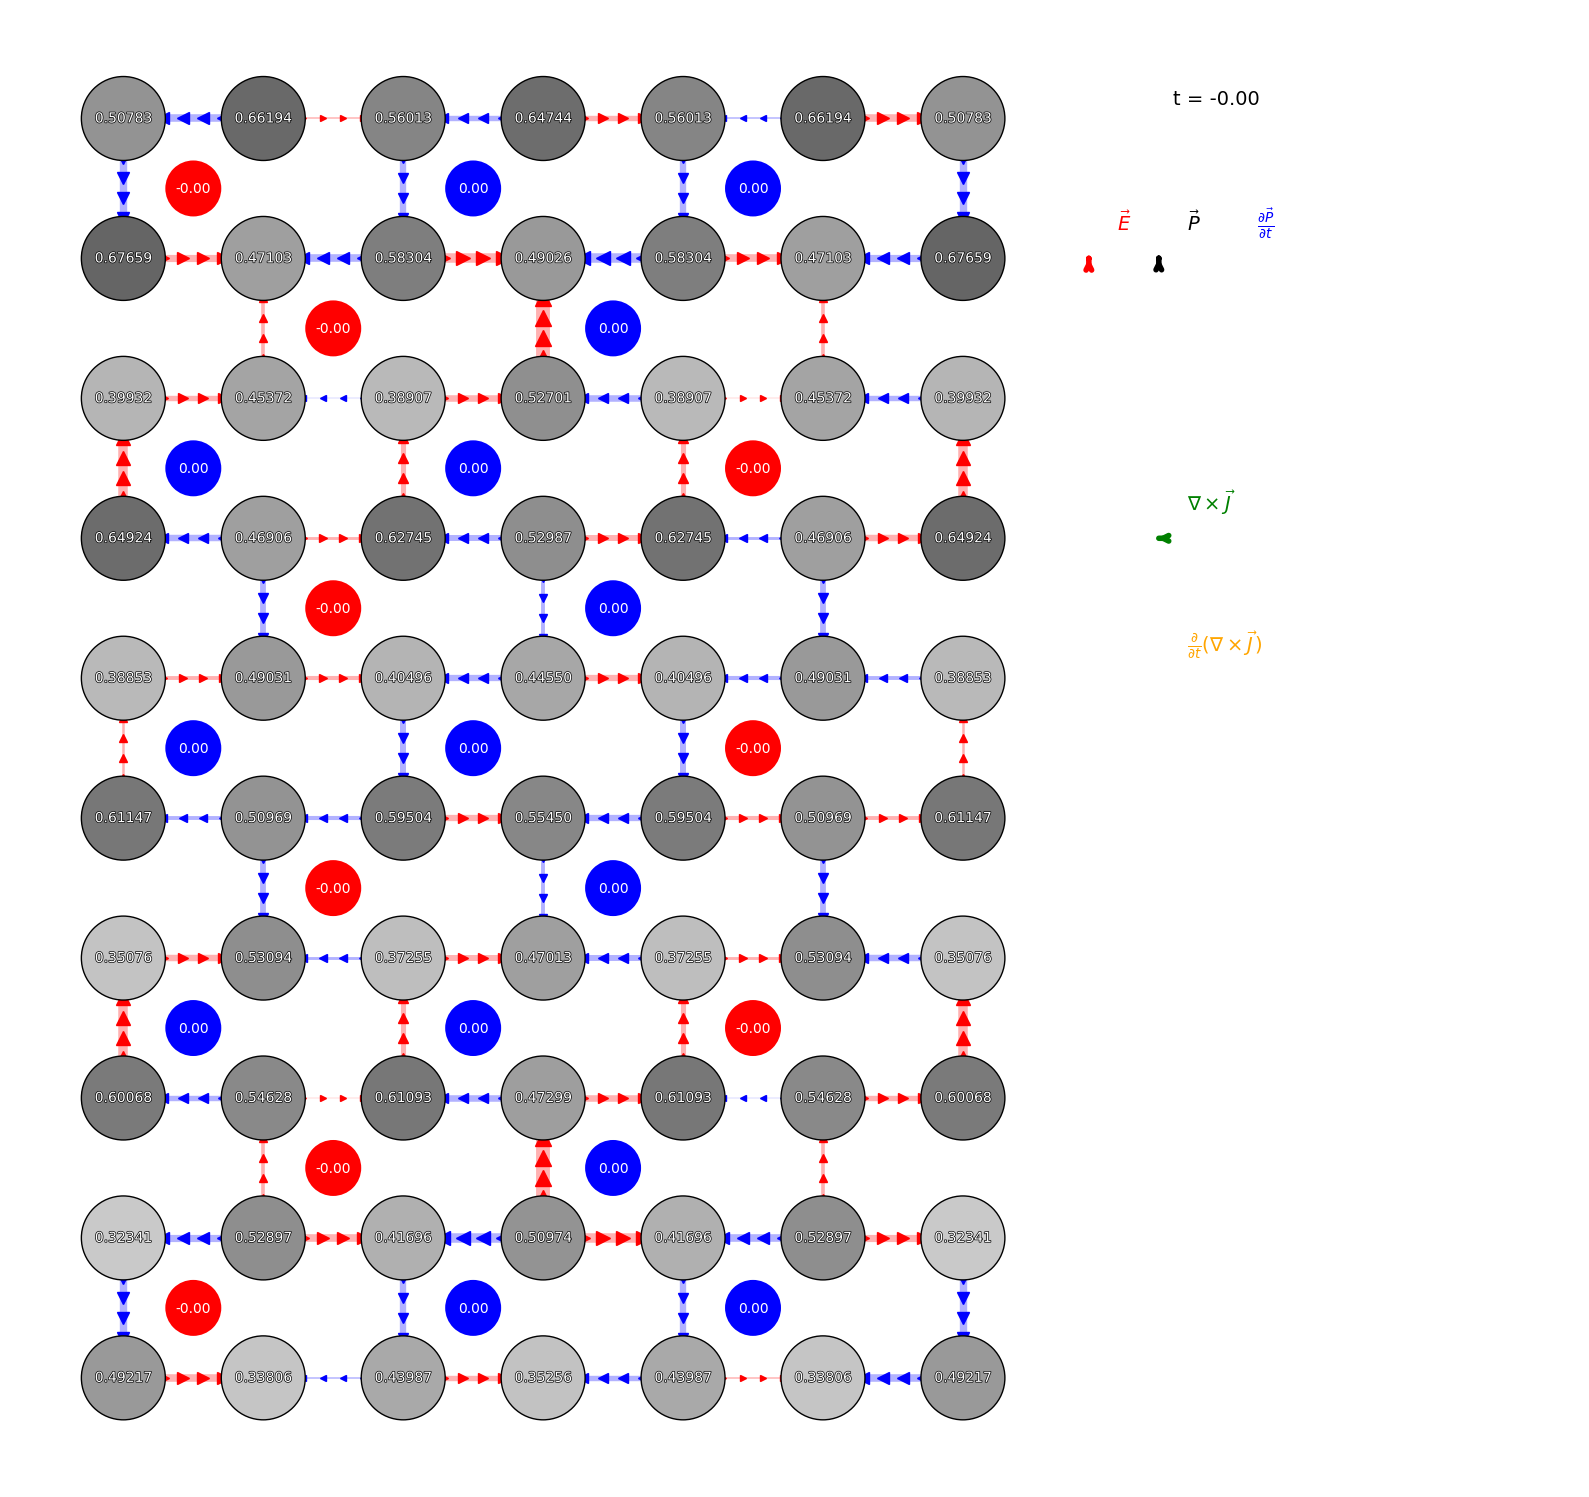

10.0%. Run time:  13.52s. Est. time left: 00:00:02:01
20.0%. Run time:  20.71s. Est. time left: 00:00:01:22
30.0%. Run time:  29.57s. Est. time left: 00:00:01:08
40.0%. Run time:  37.09s. Est. time left: 00:00:00:55
50.0%. Run time:  44.31s. Est. time left: 00:00:00:44
60.0%. Run time:  54.39s. Est. time left: 00:00:00:36
70.0%. Run time:  61.77s. Est. time left: 00:00:00:26
80.0%. Run time:  69.77s. Est. time left: 00:00:00:17
90.0%. Run time:  78.25s. Est. time left: 00:00:00:08
100.0%. Run time:  85.75s. Est. time left: 00:00:00:00
Total run time:  85.75s


Generating animation: 100%|██████████| 100/100 [00:38<00:00,  2.62frame/s]


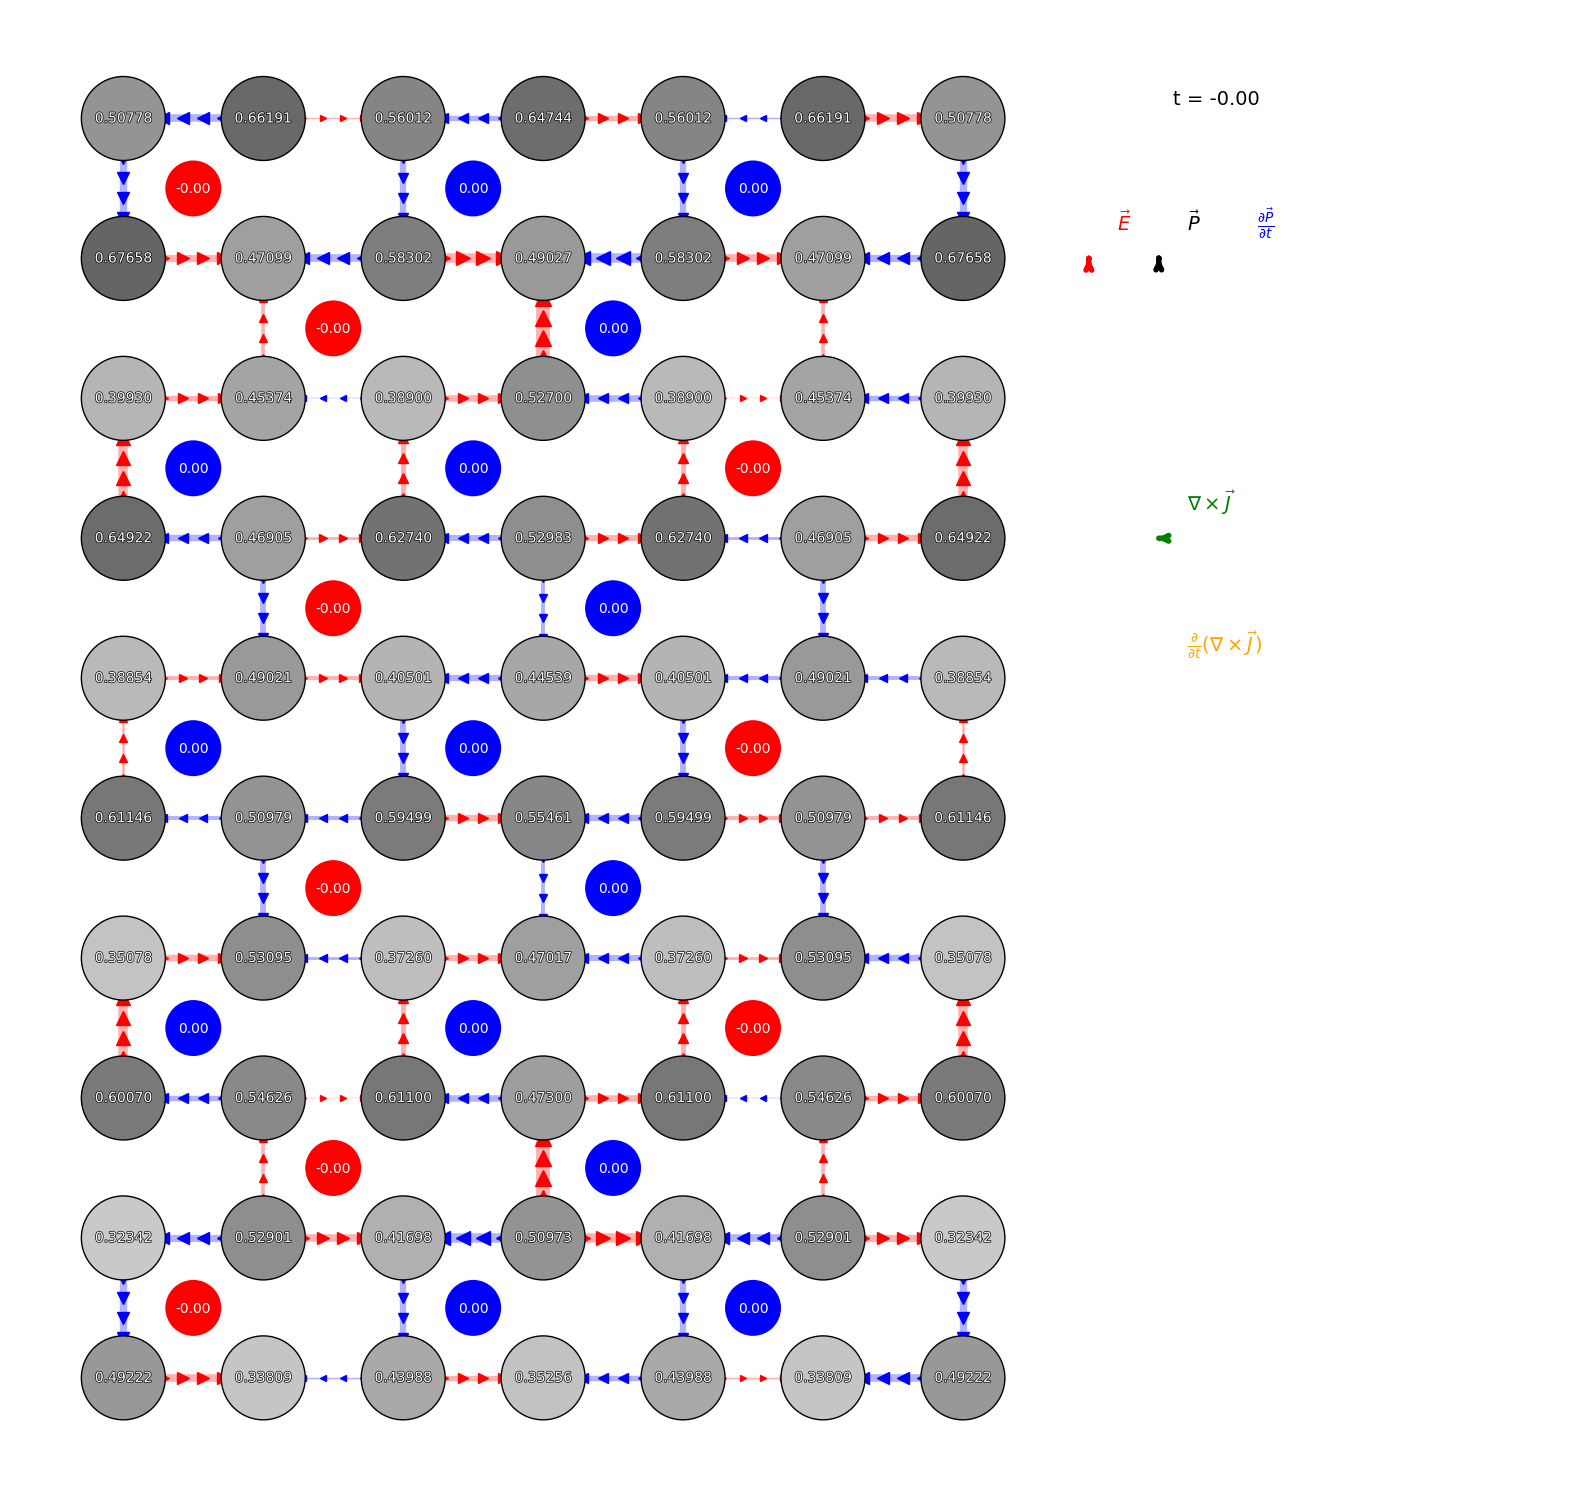

In [3]:
geometry = BrickwallLatticeGeometry((7, 10))
params = SimulationParameters(t_hop=1.0, E_amplitude=np.sin, E_direction=np.array([0, -1]), h=0.001, T=20, charge=1, initial_occupation=0.5)
lattice = Lattice2D(geometry, params)

lattice.evolve(force_reevolve=True, solver="rk4", use_sparse=True)
lattice.save_current_density_animation("test_solvers_rk4_sparse.gif", sample_every=200, fps=10)
lattice.plot_current_density(-1)

lattice.evolve(force_reevolve=True, solver="rk4", use_sparse=False)
lattice.save_current_density_animation("test_solvers_rk4_dense.gif", sample_every=200, fps=10)
lattice.plot_current_density(-1)

lattice.evolve(force_reevolve=True, solver="qutip", options={"progress_bar": True})
lattice.save_current_density_animation("test_solvers_qutip.gif", sample_every=200, fps=10)
lattice.plot_current_density(-1)

In [12]:
omega = 2 * np.pi / 3
T = 2 * np.pi / omega

def E(t):
    return np.cos(omega * t)

l = Lattice2D(
    dimensions=(4, 20),
    t_hop=1,
    E_amplitude=E,
    E_dir=np.array([1, 0]),
    h=5e-3,
    T=50 * T,
    initial_occupation=0.5,
)

In [8]:
class DiscreteField2D:
    def __init__(self, field: np.ndarray):
        self._field = None
        self.field = field

    @property
    def field(self) -> np.ndarray:
        return self._field

    @field.setter
    def field(self, field: np.ndarray):
        self._field = field
        self.gradient_field = np.gradient(self._field, edge_order=1)

    @property
    def gradient(self) -> np.ndarray:
        grad_x, grad_y = self.gradient_field
        return np.array([np.mean(grad_x), np.mean(grad_y)])


class CurlField(DiscreteField2D):
    @classmethod
    def from_curl_dict(cls, curl_dict: dict[int, np.float64], cell_width: int, cell_height: int, Lx: int, Ly: int) -> "CurlField":
        cell_shape = np.array([cell_width, cell_height])
        field = np.zeros((Ly // cell_height - 1, Lx // cell_width - 1), dtype=float)

        for site_index, curl_val in curl_dict.items():
            i, j = site_index // (Lx * cell_height), site_index % Lx
            field[i, j] = curl_val
        return cls(field)

In [11]:
l = Lattice2D(geometry=RectangularLatticeGeometry((4, 10)), simulation_parameters=SimulationParameters(1, 1, [1, 0], 0.01, 10, 1, 0.5))

l.evolve()

c = CurlField.from_curl_dict(l.states[-1].curl, l.geometry.cell_width, l.geometry.cell_height, l.Lx, l.Ly)

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


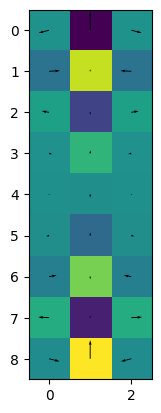

[ 1.3327996e-03 -9.3341808e-14]


In [13]:
plt.imshow(c.field)
plt.quiver(*np.meshgrid(np.arange(c.field.shape[1]), np.arange(c.field.shape[0])), c.gradient_field[1], c.gradient_field[0])
plt.show()
print(c.gradient)